In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
from transformers import get_scheduler
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# new file
from rules_polypersonal_combo import preprocess_texts


In [2]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=27)  # adjust num_labels as necessary

Some weights of the model checkpoint at Llamacha/QuBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You s

In [3]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [4]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [5]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        print("dialect: ", dialect)
        for filename in os.listdir(directory_path):
            if filename.endswith('.txt'):
                print("filename: ", filename)
                file_path = os.path.join(directory_path, filename)
                with open(file_path, 'r', encoding='latin-1') as file:
                    text = file.read().strip()
                    # Quick debug: peek at the text
                    # print("First 500 chars:", text[:500])
                    # print("Last  500 chars:", text[-500:])

                    text = remove_numbers(text)
                    # Determine tags for this text
                    tags = preprocess_texts(text)
                    print("File is tagged with: ", tags)

                    # Split the original text into chunks
                    chunks = split_document(text)
                    print("document is in ", len(chunks), " chunks")

                    # If you suspect chunk-level differences, optionally inspect the first chunk:
                    # if chunks:
                    #     print("First chunk excerpt:", chunks[0][:200])

                    for chunk in chunks:
                        # Another debug: show polypersonal tags for each chunk if needed
                        chunk_tags = preprocess_texts(chunk)
                        print("Tags for this chunk:", chunk_tags)

                        chunk_with_tags = f"{tags} {chunk}"
                        encoded_text = tokenizer(
                            chunk_with_tags,
                            truncation=True,
                            padding='max_length',
                            max_length=512,
                            return_tensors="pt"
                        )
                        input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                        attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                        processed_data.append({
                            'input_ids': input_ids_list,
                            'attention_mask': attention_mask_list,
                            'labels': label_dict[dialect]
                        })
    return processed_data


In [6]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [7]:

# so just the bibles data 
directory_paths = {
    'inb': '../language_resources/new_scraped_bible/inb',
    'qub': '../language_resources/new_scraped_bible/qub',
    'quf': '../language_resources/new_scraped_bible/quf',
    'quh': '../language_resources/new_scraped_bible/quh',
    'qul': '../language_resources/new_scraped_bible/qul',
    'qup': '../language_resources/new_scraped_bible/qup',
    'quw': '../language_resources/new_scraped_bible/quw',
    'quy': '../language_resources/new_scraped_bible/quy',
    'quz': '../language_resources/new_scraped_bible/quz', 
    'qvc': '../language_resources/new_scraped_bible/qvc',
    'qve': '../language_resources/new_scraped_bible/qve',  
    'qvi': '../language_resources/new_scraped_bible/qvi',
    'qvh': '../language_resources/new_scraped_bible/qvh',
    'qvm': '../language_resources/new_scraped_bible/qvm',
    'qvn': '../language_resources/new_scraped_bible/qvn',
    'qvo': '../language_resources/new_scraped_bible/qvo',
    'qvs': '../language_resources/new_scraped_bible/qvs',
    'qvw': '../language_resources/new_scraped_bible/qvw',
    'qvz': '../language_resources/new_scraped_bible/qvz',
    'qwh': '../language_resources/new_scraped_bible/qwh',
    'qxl': '../language_resources/new_scraped_bible/qxl',
    'qxh': '../language_resources/new_scraped_bible/qxh',
    'qxn': '../language_resources/new_scraped_bible/qxn',
    'qxo': '../language_resources/new_scraped_bible/qxo',
    'qxr': '../language_resources/new_scraped_bible/qxr'
}


# go through loading & processing
processed_data = load_and_preprocess(directory_paths)

dialect:  inb
filename:  INBWBT_1JN.txt
File is tagged with:  <TAG_tata> <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_runa> <TAG_kari> <VERB_murka> <VERB_wanka>
document is in  11  chunks
Tags for this chunk: <TAG_taita> <TAG_alpa> <VERB_murka> <VERB_wanka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_runa> <VERB_murka> <VERB_wanka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <VERB_murka> <VERB_wanka>
Tags for this chunk: <TAG_tata> <TAG_taita> <TAG_alpa> <VERB_wanka>
Tags for this chunk: <TAG_tata> <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_kari> <VERB_murka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_kari> <VERB_murka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <TAG_runa> <VERB_murka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_runa> <VERB_murka>
Tags for this chunk: <TAG_tata> <TAG_taita> <TAG_alpa> <TAG_indi> <TAG_runa> <VERB_murka>
Tags for this chunk: <TAG_taita> <TAG_alpa> <TAG_runa> <VERB_murka>
Tags for this chunk: <TAG_tata> <TAG_taita> 

In [8]:

# Create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)



In [9]:
# List to store accuracy per epoch
epoch_accuracy = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Increased epochs
    # per_device_train_batch_size=10,  # Slightly larger batch size - original
    per_device_train_batch_size=20,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [11]:
trainer.train()

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 22385
  Num Epochs = 1
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 1120
  Number of trainable parameters = 83471643


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1120 [00:00<?, ?it/s]

{'loss': 3.3415, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.2501, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.1971, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.1689, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 3.1138, 'learning_rate': 5e-06, 'epoch': 0.04}
{'loss': 3.0685, 'learning_rate': 6e-06, 'epoch': 0.05}
{'loss': 3.0474, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.06}
{'loss': 3.0124, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.07}
{'loss': 3.0236, 'learning_rate': 9e-06, 'epoch': 0.08}
{'loss': 2.9923, 'learning_rate': 1e-05, 'epoch': 0.09}
{'loss': 2.8599, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.1}
{'loss': 2.7967, 'learning_rate': 1.2e-05, 'epoch': 0.11}
{'loss': 2.5999, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.12}
{'loss': 2.4145, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.12}
{'loss': 2.4159, 'learning_rate': 1.5e-05, 'epoch': 0.13}
{'loss': 2.0972, 'learni

***** Running Evaluation *****
  Num examples = 3951
  Batch size = 15


{'loss': 0.0061, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/264 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1120
Configuration saved in ./results/checkpoint-1120/config.json


{'eval_loss': 0.01160913985222578, 'eval_accuracy': 0.9974689951910909, 'eval_f1': 0.9974717385886732, 'eval_precision': 0.9974947708984562, 'eval_recall': 0.9974689951910909, 'eval_runtime': 334.0939, 'eval_samples_per_second': 11.826, 'eval_steps_per_second': 0.79, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-1120/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1120 (score: 0.9974689951910909).


{'train_runtime': 9965.3658, 'train_samples_per_second': 2.246, 'train_steps_per_second': 0.112, 'train_loss': 0.6989586151171742, 'epoch': 1.0}


TrainOutput(global_step=1120, training_loss=0.6989586151171742, metrics={'train_runtime': 9965.3658, 'train_samples_per_second': 2.246, 'train_steps_per_second': 0.112, 'train_loss': 0.6989586151171742, 'epoch': 1.0})

Train the model then save the model path so it can be used for unclassified data

In [12]:
model_path = './models/neural_rules_3'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in ./models/neural_rules_3/config.json
Model weights saved in ./models/neural_rules_3/pytorch_model.bin
tokenizer config file saved in ./models/neural_rules_3/tokenizer_config.json
Special tokens file saved in ./models/neural_rules_3/special_tokens_map.json


('./models/neural_rules_3/tokenizer_config.json',
 './models/neural_rules_3/special_tokens_map.json',
 './models/neural_rules_3/vocab.json',
 './models/neural_rules_3/merges.txt',
 './models/neural_rules_3/added_tokens.json',
 './models/neural_rules_3/tokenizer.json')

In [13]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels


***** Running Prediction *****
  Num examples = 3951
  Batch size = 15


  0%|          | 0/264 [00:00<?, ?it/s]

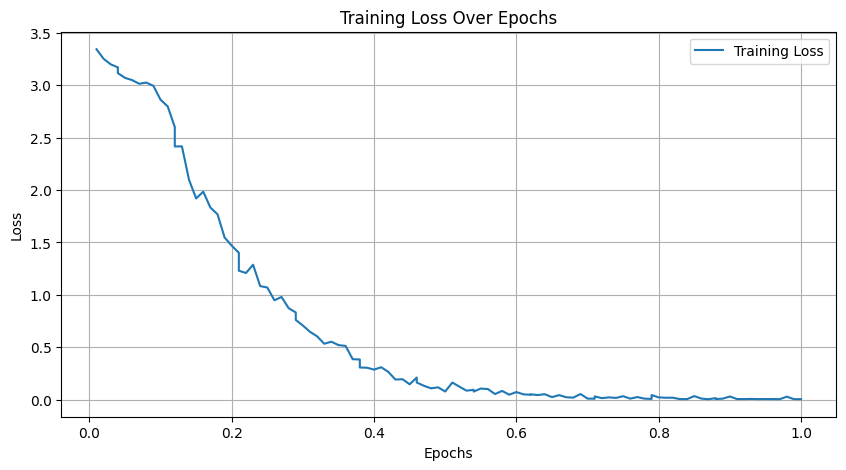

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)


/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_6327/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_6327/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         inb       1.00      1.00      1.00       124
         qub       1.00      1.00      1.00        91
         quf       1.00      1.00      1.00       115
         quh       0.99      1.00      0.99        97
         qul       1.00      0.99      0.99        96
         qup       1.00      1.00      1.00       159
         quw       1.00      0.99      1.00       106
         quy       1.00      1.00      1.00       419
         quz       1.00      1.00      1.00       425
         qvc       1.00      1.00      1.00       145
         qve       1.00      0.99      1.00       123
         qvi       0.99      1.00      1.00       130
         qvh       1.00      1.00      1.00        84
         qvm       1.00      0.99      0.99        95
         qvn       0.98      1.00      0.99       109
         qvo       1.00      1.00      1.00       106
         qvs       1.00      1.00      1.00       107
   

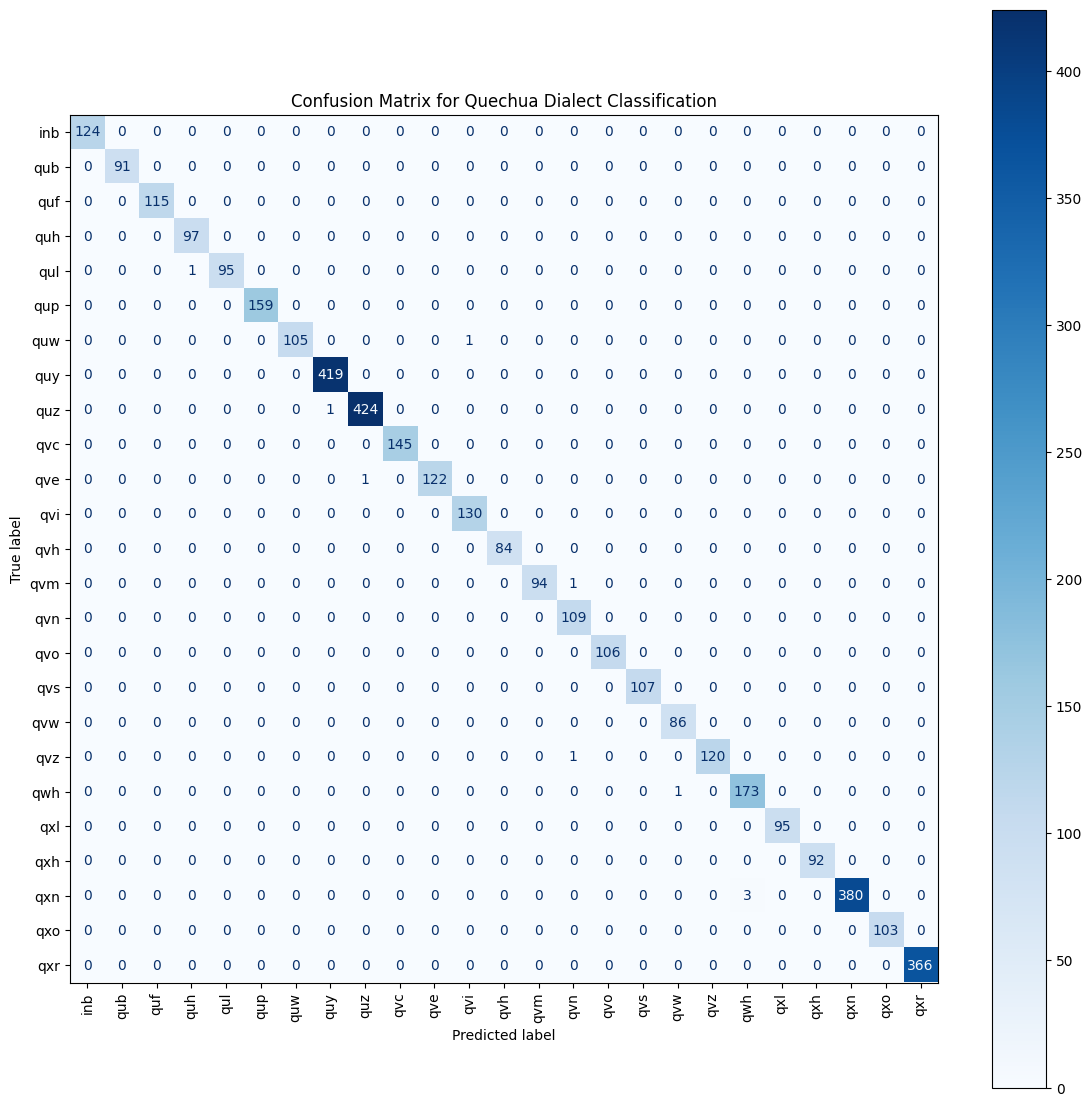

In [16]:
# Extract dialect names from the directory paths
dialect_labels = list(directory_paths.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dialect_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as necessary for readability
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix for Quechua Dialect Classification')
plt.show()

<Figure size 1000x700 with 0 Axes>

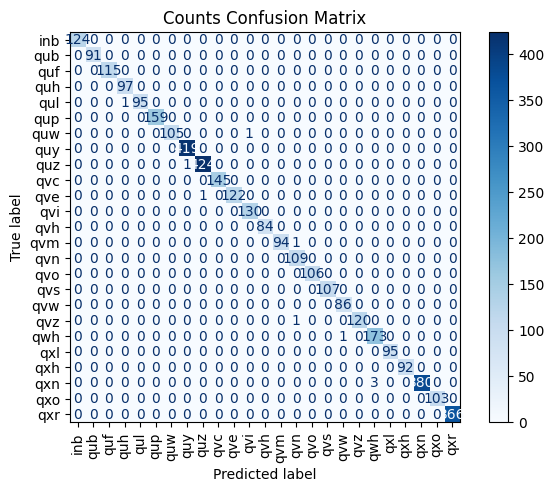

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout
plt.title("Counts Confusion Matrix")
plt.show()

Normalized Confusion Matrix

<Figure size 1000x700 with 0 Axes>

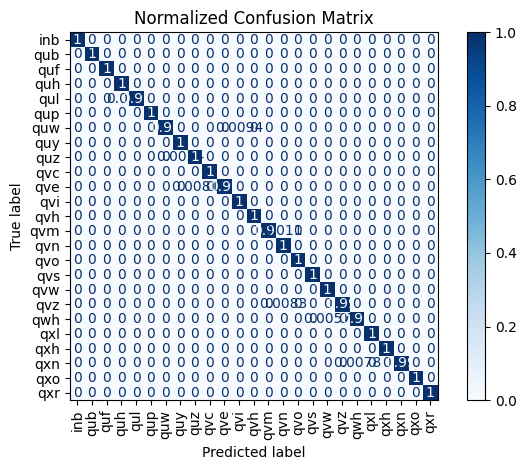

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adjust layout
plt.show()

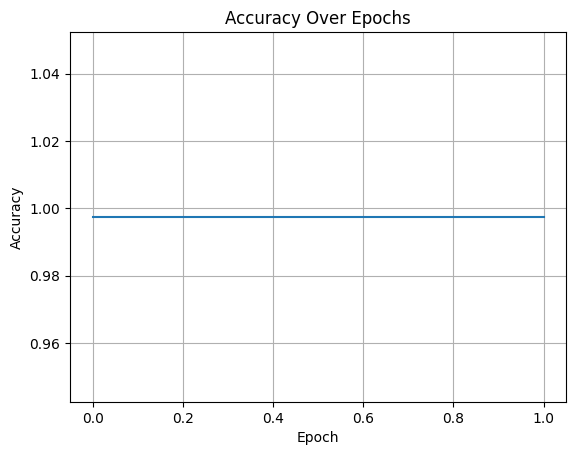

In [19]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

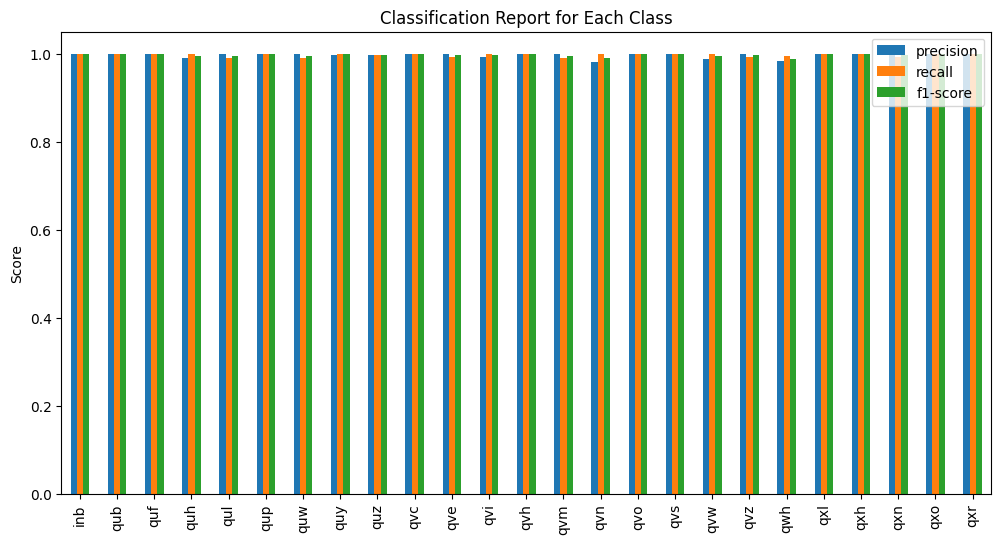

In [20]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, target_names=directory_paths.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)  # Drop averages/total
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report for Each Class')
plt.ylabel('Score')
plt.show()
